### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import torch
import tarfile
import argparse
from torch.utils.data import DataLoader
from sp4asc.datasets.dcase import DCaseDataset
from sp4asc.models import get_net
from sp4asc.models.cnns import LogMelSpectrogram
from sp4asc.training import TrainingManager

import warnings
warnings.filterwarnings("ignore")

In [2]:
import librosa

In [3]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

(128, 431)


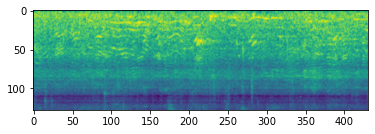

In [4]:
path = "TAU_SMALL_DATASET/test/airport-barcelona-203-6131-s6.wav"
spec = get_melspectrogram_db(path)
print(spec.shape)
plt.imshow(spec_to_image(spec))


In [5]:
import shutil
from playsound import playsound
destination="test.wav"
shutil.copyfile(path, destination)
# playsound("test.wav")
os.remove("test.wav")


In [6]:
import torch.nn as nn
from sp4asc.models.cnns import Cnn6_60k
from torchsummary import summary

model = Cnn6_60k(dropout=0.2, spec_aug = [128, 2, 32, 2])

In [7]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

62922

In [13]:
dataset= DCaseDataset(root_dir='TAU_SMALL_DATASET', split="test")
dataset

In [12]:
 loader_train = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        pin_memory=True,
        num_workers=2,
        drop_last=True,
    )